# Setup

In [ ]:
!pip install -q transformers
!pip install -q datasets
!pip install -q emoji

     |████████████████████████████████| 3.8 MB 15.3 MB/s 
     |████████████████████████████████| 596 kB 56.4 MB/s 
     |████████████████████████████████| 895 kB 51.0 MB/s 
     |████████████████████████████████| 6.5 MB 39.5 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 311 kB 13.2 MB/s 
     |████████████████████████████████| 1.1 MB 54.2 MB/s 
     |████████████████████████████████| 212 kB 63.2 MB/s 
     |████████████████████████████████| 134 kB 54.9 MB/s 
     |████████████████████████████████| 271 kB 60.3 MB/s 
     |████████████████████████████████| 144 kB 68.8 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 174 kB 15.1 MB/s 


In [ ]:
import emoji
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import pipeline
from sklearn.metrics import classification_report

# Dataset Exploration

We make use of the [TweetEval dataset](https://huggingface.co/datasets/tweet_eval), particularly its "emoji" subdataset. 

Below, we examine the label distribution of its different splits.

In [ ]:
dataset = load_dataset("tweet_eval", "emoji")

dataset

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/30.4k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/159k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.57k [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/emoji/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

In [ ]:
emoji_labels = dataset['train'].features['label'].names
id2label = dict(zip(range(len(emoji_labels)), emoji_labels))

emojis = []
for i in range(len(emoji_labels)):
    emojis.append(emoji.demojize(id2label[i]) + ' ' + id2label[i])
emojis

[':red_heart: ❤',
 ':smiling_face_with_heart-eyes: 😍',
 ':face_with_tears_of_joy: 😂',
 ':two_hearts: 💕',
 ':fire: 🔥',
 ':smiling_face_with_smiling_eyes: 😊',
 ':smiling_face_with_sunglasses: 😎',
 ':sparkles: ✨',
 ':blue_heart: 💙',
 ':face_blowing_a_kiss: 😘',
 ':camera: 📷',
 ':United_States: 🇺🇸',
 ':sun: ☀',
 ':purple_heart: 💜',
 ':winking_face: 😉',
 ':hundred_points: 💯',
 ':beaming_face_with_smiling_eyes: 😁',
 ':Christmas_tree: 🎄',
 ':camera_with_flash: 📸',
 ':winking_face_with_tongue: 😜']

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128293 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 10024 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128247 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font

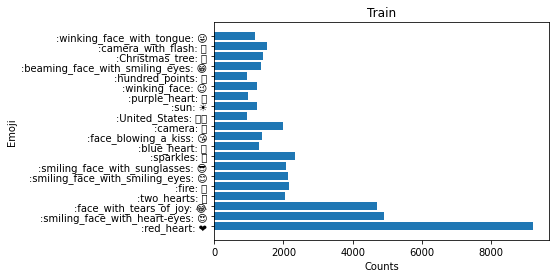

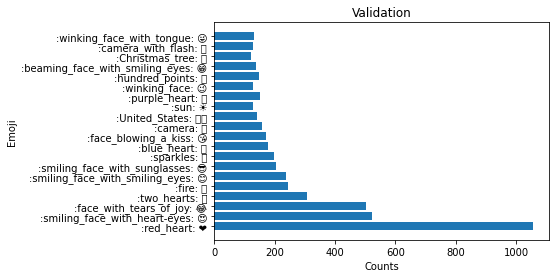

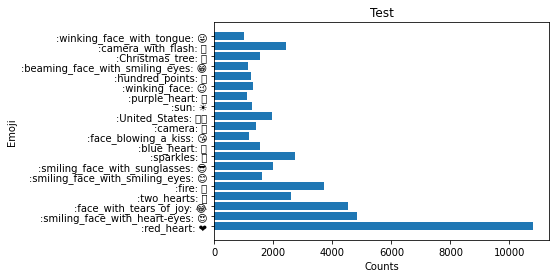

In [ ]:
def count_labels(split):
  counts = [0] * len(emojis)
  for row in dataset[split]:
    counts[row['label']] += 1
  return counts

train_label_counts = count_labels('train')
validation_label_counts = count_labels("validation")
test_label_counts = count_labels('test')

def bar_plot(data, name):
  plt.barh(range(len(emojis)), data)
  plt.yticks(range(len(emojis)), emojis)
  plt.title(name)
  plt.xlabel('Counts')
  plt.ylabel("Emoji")
  plt.show()
  
bar_plot(train_label_counts, "Train")
bar_plot(validation_label_counts, "Validation")
bar_plot(test_label_counts, "Test")

# Model Evaluation

Given the directory to a trained model, here we do a more robust evaluation of its performance on our test-set. 

In [ ]:
def generate_predictions_vinai(model_dir):
  tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True, use_fast=True, device=0)
  emojify = pipeline("text-classification", model=model_dir, tokenizer=tokenizer)
  tokenizer_kwargs = {'padding':True,'truncation':True}
  return emojify(dataset['test']['text'], **tokenizer_kwargs)

def generate_predictions_bert(model_dir):
  tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)
  emojify = pipeline("text-classification", model="bert-base-default", tokenizer=tokenizer, device=0)
  tokenizer_kwargs = {'padding':True,'truncation':True}
  return emojify(dataset['test']['text'], **tokenizer_kwargs)

def evaluate_model_from_predictions(predictions):
  error_counts = [0] * len(emojis)
  errors = []
  error_correct_lbls = []
  error_pred_lbls = []
  label_to_id = inv_map = {v: k for k, v in id2label.items()}
  print(label_to_id)

  for text, label, prediction_entry in zip(dataset['test']['text'], dataset['test']['label'], predictions):
      pred_label_id = label_to_id[prediction_entry['label']]
      if label != pred_label_id:
          error_counts[label] += 1
          error_correct_lbls.append(id2label[pred_label_id])
          error_pred_lbls.append(id2label[label])
          errors.append(text)

  bar_plot(error_counts, 'Errors')
  print(classification_report(dataset['test']['label'], [label_to_id[p['label']] for p in predictions], 
                        target_names=[id2label[i] for i in range(len(emojis))]))
  return (errors, error_correct_lbls, error_pred_lbls)

## BERTTweet Base Model Evaluation

In [ ]:
predictions = generate_predictions_vinai('/content/base_model')

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'❤': 0, '😍': 1, '😂': 2, '💕': 3, '🔥': 4, '😊': 5, '😎': 6, '✨': 7, '💙': 8, '😘': 9, '📷': 10, '🇺🇸': 11, '☀': 12, '💜': 13, '😉': 14, '💯': 15, '😁': 16, '🎄': 17, '📸': 18, '😜': 19}


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128293 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 10024 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128247 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font

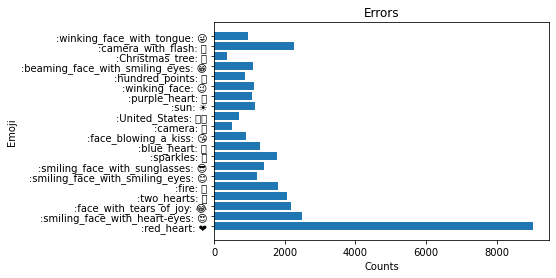

              precision    recall  f1-score   support

           ❤       0.67      0.16      0.26     10798
           😍       0.25      0.48      0.33      4830
           😂       0.45      0.52      0.48      4534
           💕       0.18      0.20      0.19      2605
           🔥       0.63      0.52      0.57      3716
           😊       0.11      0.24      0.15      1613
           😎       0.15      0.29      0.20      1996
           ✨       0.30      0.35      0.32      2749
           💙       0.15      0.17      0.15      1549
           😘       0.13      0.23      0.16      1175
           📷       0.30      0.64      0.41      1432
          🇺🇸       0.52      0.65      0.57      1949
           ☀       0.72      0.08      0.14      1265
           💜       0.17      0.04      0.07      1114
           😉       0.13      0.14      0.13      1306
           💯       0.27      0.30      0.28      1244
           😁       0.12      0.06      0.08      1153
           🎄       0.62    

In [ ]:
error_text, correct_labels, pred_labels = evaluate_model_from_predictions(predictions)

In [ ]:
for text, corr_label, pred_label in zip(error_text, correct_labels, pred_labels):
  print("Text: {}".format(text))
  print("Correct Label: {}".format(corr_label))
  print("Predicted Label: {}".format(pred_label))

Streaming output truncated to the last 5000 lines.
Correct Label: ❤
Predicted Label: 💕
Text: Happier than ever with my (slightly annoying but I still love him) man @ Weborg 21 Centre
Correct Label: 💙
Predicted Label: 😍
Text: Fall color in Northern VA #occoquanregionalpark •••#novaparks #fallcolors #fallcolours…
Correct Label: 💙
Predicted Label: 😍
Text: I'm hanging with Betty McKinley #MovieNiteAtTheHill. She looks absolutely amazing @ Mars Hill…
Correct Label: 😍
Predicted Label: 😁
Text: Tis the season for the Evoke holiday party and reuniting with some of my favorite coworkers! @user
Correct Label: 🎄
Predicted Label: ✨
Text: Nice little edit of the stang •••Video Creds : lukekent14…
Correct Label: 📷
Predicted Label: 🇺🇸
Text: Out for a birthday dinner treat with these three clowns. #IHaveTheBestFriends #lovemyboys @user
Correct Label: 😊
Predicted Label: 💙
Text: Seinfeld Stance #festivious#kramer @ Red Fly Clothing
Correct Label: 😂
Predicted Label: 😜
Text: Money Bagg Yo was lit last week

## Vanilla BERT Model Evaluation

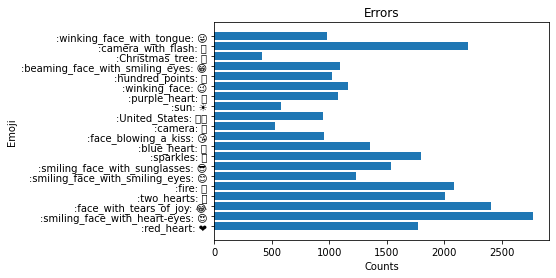

              precision    recall  f1-score   support

           ❤       0.88      0.84      0.86     10798
           😍       0.31      0.43      0.36      4830
           😂       0.40      0.47      0.43      4534
           💕       0.24      0.23      0.23      2605
           🔥       0.58      0.44      0.50      3716
           😊       0.14      0.24      0.17      1613
           😎       0.17      0.23      0.20      1996
           ✨       0.29      0.34      0.31      2749
           💙       0.15      0.12      0.14      1549
           😘       0.16      0.19      0.17      1175
           📷       0.29      0.63      0.40      1432
          🇺🇸       0.67      0.51      0.58      1949
           ☀       0.66      0.54      0.59      1265
           💜       0.21      0.03      0.06      1114
           😉       0.12      0.11      0.12      1306
           💯       0.21      0.18      0.19      1244
           😁       0.13      0.05      0.07      1153
           🎄       0.66    

In [ ]:
predictions = generate_predictions_bert('./bert-base-default')
evaluate_model_from_predictions(predictions)